<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [2]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.





Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   40G   69G  37% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
tmpfs           6.4G   60K  6.4G   1% /var/colab
/dev/sda1       114G   43G   72G  38% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           108G   43G   66G  40% /content/gdrive




              total        used        free      shared  buff/cache   available
Mem:          13021         696       11115           1        1208       12065
Swap:             0           0           0




Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s)

#### Setup logging

In [3]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [4]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [5]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



plot = Plot()
plot_adaptive = Plot()

## Extract train and test instances

In [6]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [7]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

def get_checkpoint_callback(name):
    checkpoint_filepath = f"/content/gdrive/MyDrive/DeepLearningAssignment2/checkpoints-{name}-checkpoint"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## 1. Build a model generator

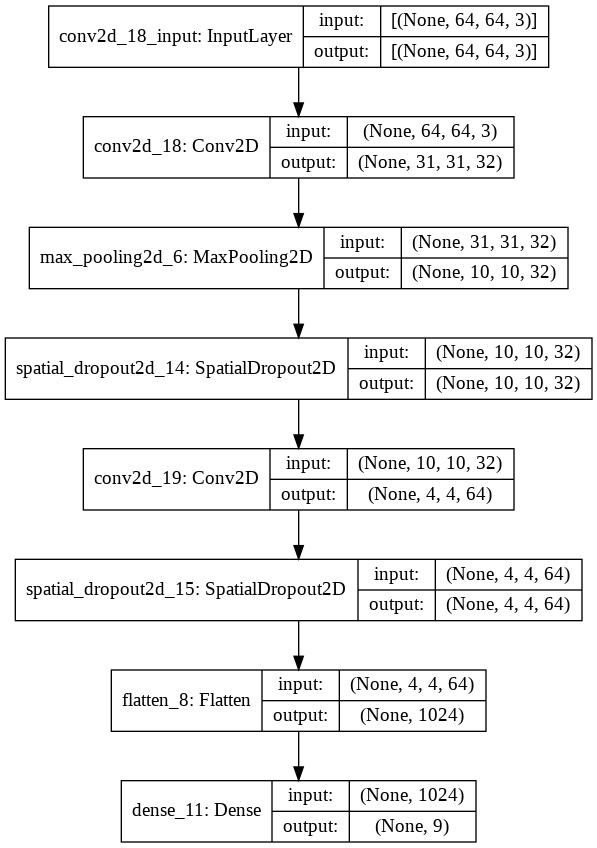

Model: "thismodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 31, 31, 32)        1568      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
spatial_dropout2d_14 (Spatia (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)          32832     
_________________________________________________________________
spatial_dropout2d_15 (Spatia (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 92

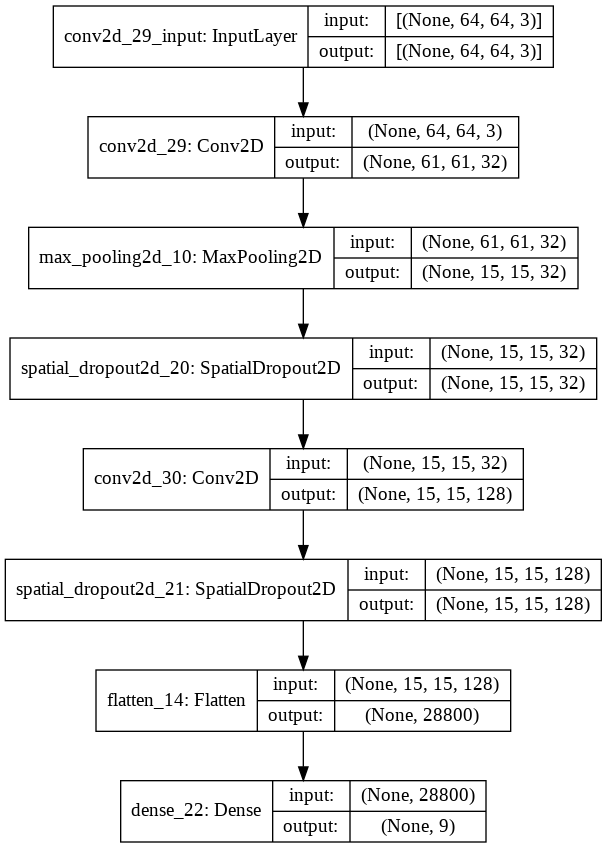

Model: "thismodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 61, 61, 32)        1568      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
spatial_dropout2d_20 (Spatia (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 128)       65664     
_________________________________________________________________
spatial_dropout2d_21 (Spatia (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 25

In [11]:
import random
import gc
plot2 = Plot()
class ModelFactory:
    @staticmethod
    def get_conv_layer(depth, inshape=None, force_stride_size=False):
        out_layers = []
        filter_size = random.choice([2, 3, 4, 5])
        stride_size = random.choice([1, 2, 3])
        stride_size = stride_size if stride_size < filter_size else filter_size

        # In case there is an exception, the caller will
        # set this and call again
        stride_size = 1 if force_stride_size else stride_size

        stride_size = (stride_size, stride_size, )
        filter_shape = tuple([filter_size, filter_size,])
        act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
        pd = random.choice(['same', 'valid'])

        if None != inshape:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                input_shape=inshape,\
                                                strides=stride_size,\
                                                activation=act_fn)
        else:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                strides=stride_size,\
                                                activation=act_fn)
        out_layers.append(conv_layer)

        if random.choice([True, False]):
            pool_size = random.choice([2, 3, 4])
            out_layers.append(tf.keras.layers.MaxPooling2D(\
                                                           pool_size,\
                                                           pool_size,))
        
        if random.choice([True, False]):
            out_layers.append(tf.keras.layers.SpatialDropout2D(0.25))

        return out_layers

    @staticmethod
    def generate_model_internal(inshp, nlabels:int, modelname:str, fss:bool):
        layer_neurons = []
        n_conv_layers = random.choice([1, 2, 3,])
        layer_depth = sorted([\
                random.choice([32, 64, 128, 256, 512, 1024]) \
                    for _ in range(n_conv_layers)])

        for i in range(1, len(layer_depth)):
            if layer_depth[i] <= layer_depth[i-1]:
                layer_depth[i] = 2 * layer_depth[i-1]

        # Add the first Convolutional layer
        model = tf.keras.Sequential(name=modelname)
        for lyr in ModelFactory.get_conv_layer(layer_depth[0], inshp, force_stride_size=fss):
            model.add(lyr)
        
        # Add zero or more additional convoluationa layer
        for d in layer_depth[1:]:
            for lyr in ModelFactory.get_conv_layer(d, inshape=None, force_stride_size=fss):
                model.add(lyr)

        # Flatten
        model.add(tf.keras.layers.Flatten())

        # Add zero or more dense layers
        n_dense = random.choice([0, 1, 2])
        for _ in range(n_dense - 1):
            act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
            layer = tf.keras.layers.Dense(\
                                random.choice([32, 64, 128, 256, 512]),
                                activation=act_fn)
            model.add(layer)
            if random.choice([True, False]):
                layer = tf.keras.layers.Dropout(0.25)
                model.add(layer)
        
        # Add the final Dense layer
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        
        return model

    @staticmethod
    def print_model(model):
        plot = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())

    @staticmethod
    def generate_model_size(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        if (-1 == max_params):
            try:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            False)
            except:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            True)
            ModelFactory.print_model(model)
            return model
        else:
            # Make 10 attempts to generate a model with the number of
            # trainable params less than the one specified
            for i in range(10):
                gc.collect()
                logging.debug(f"Attempt {i}")
                try:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                False)
                except:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                True)
                if model.count_params() < max_params:
                    ModelFactory.print_model(model)
                    gc.collect()
                    return model
                    
                gc.collect()
            return None
    
    @staticmethod
    def generate_model(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        """
        Tries to make a model with the number of trainable params less
        than the specified number. If it is not able to do so, it will
        create a model with a greater number regardless
        """
        model = ModelFactory.generate_model_size(\
                                                 inshp,\
                                                 nlabels,\
                                                 modelname,\
                                                 max_params)
        if None == model:
            model = ModelFactory.generate_model_size(\
                                                     inshp,\
                                                     nlabels,\
                                                     modelname,\
                                                     -1)
        return model



n_classes = len(np.unique(np.concatenate((trainY, valY))))
for i in range(2):
    model = ModelFactory.generate_model(trainX[0].shape, n_classes, "thismodel", 2_500_000)

In [9]:
a = [1, 2, 3, 4, 5]
for i in range(1, len(a)):
    print(a[i])

2
3
4
5
